# Introduction to pattern matching
<img src="assets/pattern.png" style="width: 80%" />

# Contents

<ul>
    <li>Introduction to regular expressions</li>
    <li>Event data</li>
    <li>Applying regular expressions to event data</li>
    <li>Finding the assist</li>
    <li>Introducing zones</li>
    <li>Plotting the results</li>
</ul>

# Intro: matching a string

In [32]:
import re

string = "1234AB"

if re.match("([0-9]{4}[A-Z]{2})", string):
    print("match")
else:
    print("no match")

match


In [33]:
string = "12345AB"

if re.match("([0-9]{4}[A-Z]{2})", string):
    print("match")
else:
    print("no match")

no match


# Intro: searching for patterns

In [34]:
import re

string = "Koen 1234AB Henk 123P8 Kees 0000BB 817 0987ZZ 9999AA"

results = re.findall("([0-9]{4}[A-Z]{2})", string)
results

['1234AB', '0000BB', '0987ZZ', '9999AA']

# Event data

In [4]:
from kloppy import datasets

dataset = datasets.load("statsbomb")
print(f"{dataset.metadata.teams[0]} - {dataset.metadata.teams[1]}")

Barcelona - Deportivo Alavés


/usr/local/lib/python3.8/site-packages/kloppy-1.4.3-py3.8.egg/kloppy/infra/datasets/event/statsbomb.py:11: UserWarning: 

You are about to use StatsBomb public data.
By using this data, you are agreeing to the user agreement. 
The user agreement can be found here: https://github.com/statsbomb/open-data/blob/master/LICENSE.pdf

  warnings.warn(


# Event data

In [5]:
import dataclasses


def print_event(event):
    for field in dataclasses.fields(event):
        if field.name == "raw_event":
            continue
        print(f"{field.name: <20}: {str(getattr(event, field.name))}")


print_event(dataset.events[21])

period              : Period(id=1, start_timestamp=0.0, end_timestamp=2705.267, attacking_direction=<AttackingDirection.NOT_SET: 'not-set'>)
timestamp           : 24.687
ball_owning_team    : Barcelona
ball_state          : BallState.ALIVE
event_id            : 126756d5-bfe3-44a7-a2c3-d36fb4d0a548
team                : Deportivo Alavés
player              : Víctor Laguardia Cisneros
coordinates         : Point(x=35.5, y=68.5)
result              : PassResult.INCOMPLETE
state               : {}
qualifiers          : []
receive_timestamp   : 28.826
receiver_player     : None
receiver_coordinates: Point(x=107.5, y=54.5)
event_type          : EventType.PASS
event_name          : pass


# Applying regular expressions to event data

<img src="assets/encode_event.png" style="width: 80%"/>

<img src="assets/encode_event2.png" style="width: 80%"/>

<img src="assets/encode_event3.png" style="width: 80%"/>

# Encoder

In [7]:
from kloppy.domain import Event


def encoder(event: Event):
    if event.event_name == "pass":
        return "P"
    elif event.event_name == "shot":
        return "S"

```python
encoded_str = "PPPPPPPPPPPPPPPPPPPPPPPSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP"
```

# Matcher

In [8]:
import re
from dataclasses import dataclass
from typing import Callable, List

from kloppy.domain import EventDataset


@dataclass
class IndexEntry:
    start_pos: int
    end_pos: int
    event: Event


class Matcher:
    def __init__(self, encoder: Callable[[Event], str]):
        self.encoder = encoder

    def search(self, dataset: EventDataset, pattern: str) -> List[List[Event]]:
        # Step 1: encode events and build index
        index = []
        encoded_str = ""
        for event in dataset.events:
            encoded_event = self.encoder(event)
            if not encoded_event:
                continue

            current_pos = len(encoded_str)
            index_entry = IndexEntry(start_pos=current_pos, end_pos=current_pos + len(encoded_event), event=event)
            index.append(index_entry)

            encoded_str += encoded_event

        # Step 2: Search using regular expression
        results = re.finditer(pattern, encoded_str)

        # Step 3: Decode back to match (List of Events)
        matches = []
        index_pos = 0
        index_length = len(index)
        for result in results:
            start_pos, end_pos = result.span()

            match = []
            for i in range(index_pos, index_length):
                index_entry = index[i]

                if index_entry.start_pos >= end_pos:
                    index_pos = i
                    break
                elif index_entry.start_pos >= start_pos:
                    match.append(index_entry.event)

            matches.append(match)

        return matches

# Searching

In [9]:
from kloppy.utils import performance_logging


def encoder(event: Event):
    if event.event_name == "pass":
        return "P"
    elif event.event_name == "shot":
        return "S"


matcher = Matcher(encoder)

with performance_logging("search"):
    results = matcher.search(dataset, pattern="PS")

print(f"Results: {len(results)}\n")

search took: 4.55ms 
Results: 27



# The results

In [14]:
from kloppy import to_pandas

print(to_pandas(results[0]))

                               event_id event_type      result  success  period_id  timestamp  end_timestamp ball_state ball_owning_team team_id player_id  coordinates_x  coordinates_y  end_coordinates_x  end_coordinates_y receiver_player_id
0  b96db2cb-9123-4596-9bfc-537a645c5991       PASS    COMPLETE     True          1    144.126        147.565      alive              217     217      5470          49.50          25.50              111.5               50.5               5503
1  65f16e50-7c5d-4293-b2fc-d20887a772f9       SHOT  OFF_TARGET    False          1    149.094            NaN      alive              217     217      5503         111.65          51.65                NaN                NaN                NaN


# The results

In [13]:
from kloppy import to_pandas

import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)


def print_results(results, limit=100):
    for i, result in enumerate(results[:limit]):
        df = to_pandas(
            result,
            additional_columns={
                "player_name": lambda event: event.player.full_name,
                "team_name": lambda event: str(event.team),
                "x": lambda event: event.coordinates.x,
                "y": lambda event: event.coordinates.y,
            },
        )
        print(f"Result {i}:")
        print(df[["timestamp", "team_name", "player_name", "event_type", "result", "x", "y"]])
        print("")

In [15]:
print_results(results)

Result 0:
   timestamp  team_name                     player_name event_type      result       x      y
0    144.126  Barcelona                    Ivan Rakitić       PASS    COMPLETE   49.50  25.50
1    149.094  Barcelona  Lionel Andrés Messi Cuccittini       SHOT  OFF_TARGET  111.65  51.65

Result 1:
   timestamp  team_name                     player_name event_type      result       x      y
0    337.369  Barcelona  Lionel Andrés Messi Cuccittini       PASS    COMPLETE   92.50  56.50
1    339.239  Barcelona                Jordi Alba Ramos       SHOT  OFF_TARGET  113.95  26.95

Result 2:
   timestamp         team_name                     player_name event_type    result      x      y
0    924.984  Deportivo Alavés            Rubén Duarte Sánchez       PASS  COMPLETE  23.50  33.50
1    928.625         Barcelona  Lionel Andrés Messi Cuccittini       SHOT     SAVED  91.95  34.45

Result 3:
   timestamp         team_name                      player_name event_type      result       x     

In [16]:
print_results(results[2:3])
print_results(results[12:13])
print_results(results[21:22])

Result 0:
   timestamp         team_name                     player_name event_type    result      x      y
0    924.984  Deportivo Alavés            Rubén Duarte Sánchez       PASS  COMPLETE  23.50  33.50
1    928.625         Barcelona  Lionel Andrés Messi Cuccittini       SHOT     SAVED  91.95  34.45

Result 0:
   timestamp         team_name            player_name event_type      result       x      y
0    365.421         Barcelona  Gerard Piqué Bernabéu       PASS  INCOMPLETE    2.50  67.50
1    367.400  Deportivo Alavés         Mubarak Wakaso       SHOT     BLOCKED  105.95  22.95

Result 0:
   timestamp         team_name               player_name event_type      result       x      y
0   1644.990  Deportivo Alavés        Jorge Franco Alviz       PASS  INCOMPLETE   28.50  55.50
1   1647.492         Barcelona  Luis Alberto Suárez Díaz       SHOT       SAVED  109.05  30.05



# Add teams

In [27]:
from kloppy.domain import Ground


def encoder_with_team(event: Event):
    if event.event_name == "pass":
        encoded_str = "P"
    elif event.event_name == "shot":
        encoded_str = "S"
    else:
        return None

    encoded_str += "H" if event.team.ground == Ground.HOME else "A"

    return encoded_str


matcher_with_team = Matcher(encoder_with_team)

In [18]:
with performance_logging("search"):
    results = matcher_with_team.search(dataset, pattern=r"P([AH])S(\1)")

print_results(results)

search took: 4.43ms 
Result 0:
   timestamp  team_name                     player_name event_type      result       x      y
0    144.126  Barcelona                    Ivan Rakitić       PASS    COMPLETE   49.50  25.50
1    149.094  Barcelona  Lionel Andrés Messi Cuccittini       SHOT  OFF_TARGET  111.65  51.65

Result 1:
   timestamp  team_name                     player_name event_type      result       x      y
0    337.369  Barcelona  Lionel Andrés Messi Cuccittini       PASS    COMPLETE   92.50  56.50
1    339.239  Barcelona                Jordi Alba Ramos       SHOT  OFF_TARGET  113.95  26.95

Result 2:
   timestamp         team_name                      player_name event_type      result       x      y
0    978.568  Deportivo Alavés  Manuel Alejandro García Sánchez       PASS    COMPLETE   99.50  15.50
1    979.616  Deportivo Alavés            Rubén Sobrino Pozuelo       SHOT  OFF_TARGET  109.05  38.65

Result 3:
   timestamp  team_name               player_name event_type      

In [19]:
with performance_logging("search"):
    results = matcher_with_team.search(dataset, pattern=r"P([AH])S(?!\1)")

print_results(results)

search took: 3.90ms 
Result 0:
   timestamp         team_name                     player_name event_type    result      x      y
0    924.984  Deportivo Alavés            Rubén Duarte Sánchez       PASS  COMPLETE  23.50  33.50
1    928.625         Barcelona  Lionel Andrés Messi Cuccittini       SHOT     SAVED  91.95  34.45

Result 1:
   timestamp         team_name            player_name event_type      result       x      y
0    365.421         Barcelona  Gerard Piqué Bernabéu       PASS  INCOMPLETE    2.50  67.50
1    367.400  Deportivo Alavés         Mubarak Wakaso       SHOT     BLOCKED  105.95  22.95

Result 2:
   timestamp         team_name               player_name event_type      result       x      y
0   1644.990  Deportivo Alavés        Jorge Franco Alviz       PASS  INCOMPLETE   28.50  55.50
1   1647.492         Barcelona  Luis Alberto Suárez Díaz       SHOT       SAVED  109.05  30.05



# Add zones

<img src="assets/pitch.png" style="width: 65%; margin: auto"/>

<img src="assets/pitch2.png?2" style="width: 65%; margin: auto"/>

In [20]:
zones = {
    1: ((50, 0), (120, 18)),
    2: ((50, 18), (102, 32)),
    3: ((50, 32), (102, 48)),
    4: ((50, 48), (102, 62)),
    5: ((50, 62), (120, 80)),
    6: ((102, 18), (120, 62)),
    7: ((0, 0), (60, 80)),
}

In [21]:
def encoder_with_zone(event: Event):
    if event.event_name == "pass":
        encoded_str = "P"
    elif event.event_name == "shot":
        encoded_str = "S"
    else:
        return None

    encoded_str += "H" if event.team.ground == Ground.HOME else "A"

    zone_id = None
    for zone_id_, ((topleft_x, topleft_y), (bottomright_x, bottomright_y)) in zones.items():
        if topleft_x <= event.coordinates.x < bottomright_x and topleft_y <= event.coordinates.y < bottomright_y:
            zone_id = zone_id_
            break

    if not zone_id:
        return None

    encoded_str += str(zone_id)

    return encoded_str


matcher_with_zone = Matcher(encoder_with_zone)

In [22]:
with performance_logging("search"):
    results = matcher_with_zone.search(dataset, pattern=r"(PH1)+SH")

print_results(results)

search took: 7.37ms 
Result 0:
   timestamp  team_name               player_name event_type      result       x      y
0   2431.179  Barcelona          Jordi Alba Ramos       PASS    COMPLETE   60.50   3.50
1   2434.592  Barcelona  Luis Alberto Suárez Díaz       SHOT  OFF_TARGET  109.25  29.65

Result 1:
   timestamp  team_name                player_name event_type    result       x      y
0    588.139  Barcelona  Philippe Coutinho Correia       PASS  COMPLETE   76.50  15.50
1    593.181  Barcelona           Jordi Alba Ramos       PASS  COMPLETE  111.50  13.50
2    596.388  Barcelona  Philippe Coutinho Correia       SHOT   BLOCKED   94.35  24.45

Result 2:
   timestamp  team_name                player_name event_type    result       x      y
0    925.128  Barcelona           Jordi Alba Ramos       PASS  COMPLETE   66.50  13.50
1    927.669  Barcelona            Ousmane Dembélé       PASS  COMPLETE   82.50   7.50
2    930.049  Barcelona           Jordi Alba Ramos       PASS  COMPLETE   

In [38]:
with performance_logging("search"):
    #    results = matcher_with_team.search(dataset, pattern=r"PH[234](PH[15])+SH")
    results = matcher_with_zone.search(dataset, pattern=r"PH[234]SH6")

print_results(results)

search took: 10.83ms 
Result 0:
   timestamp  team_name                     player_name event_type      result       x      y
0    337.369  Barcelona  Lionel Andrés Messi Cuccittini       PASS    COMPLETE   92.50  56.50
1    339.239  Barcelona                Jordi Alba Ramos       SHOT  OFF_TARGET  113.95  26.95

Result 1:
   timestamp  team_name               player_name event_type      result       x      y
0   1840.205  Barcelona  Luis Alberto Suárez Díaz       PASS    COMPLETE   88.50  26.50
1   1842.287  Barcelona           Ousmane Dembélé       SHOT  OFF_TARGET  108.05  27.35

Result 2:
   timestamp  team_name                     player_name event_type    result       x      y
0   2305.600  Barcelona  Lionel Andrés Messi Cuccittini       PASS  COMPLETE   77.50  41.50
1   2308.083  Barcelona                 Ousmane Dembélé       SHOT     SAVED  102.45  29.15

Result 3:
   timestamp  team_name       player_name event_type    result       x      y
0    156.575  Barcelona   Ousmane D

# Plotting the results

In [24]:
from mplsoccer.pitch import Pitch


def plot_results(results):
    pitch = Pitch(
        pitch_type="statsbomb",
        orientation="horizontal",
        pitch_color="#22312b",
        line_color="#c7d5cc",
        figsize=(16, 11),
        constrained_layout=True,
        tight_layout=False,
    )

    fig, ax = pitch.draw()

    passes = []
    for result in results:
        for i in range(len(result) - 1):
            passes.append(
                (
                    result[i].coordinates.x,
                    result[i].coordinates.y,
                    result[i + 1].coordinates.x,
                    result[i + 1].coordinates.y,
                )
            )

    x1, y1, x2, y2 = zip(*passes)

    pitch.arrows(x1, y1, x2, y2, width=2, headwidth=10, headlength=10, color="#ad993c", ax=ax, label="completed passes")

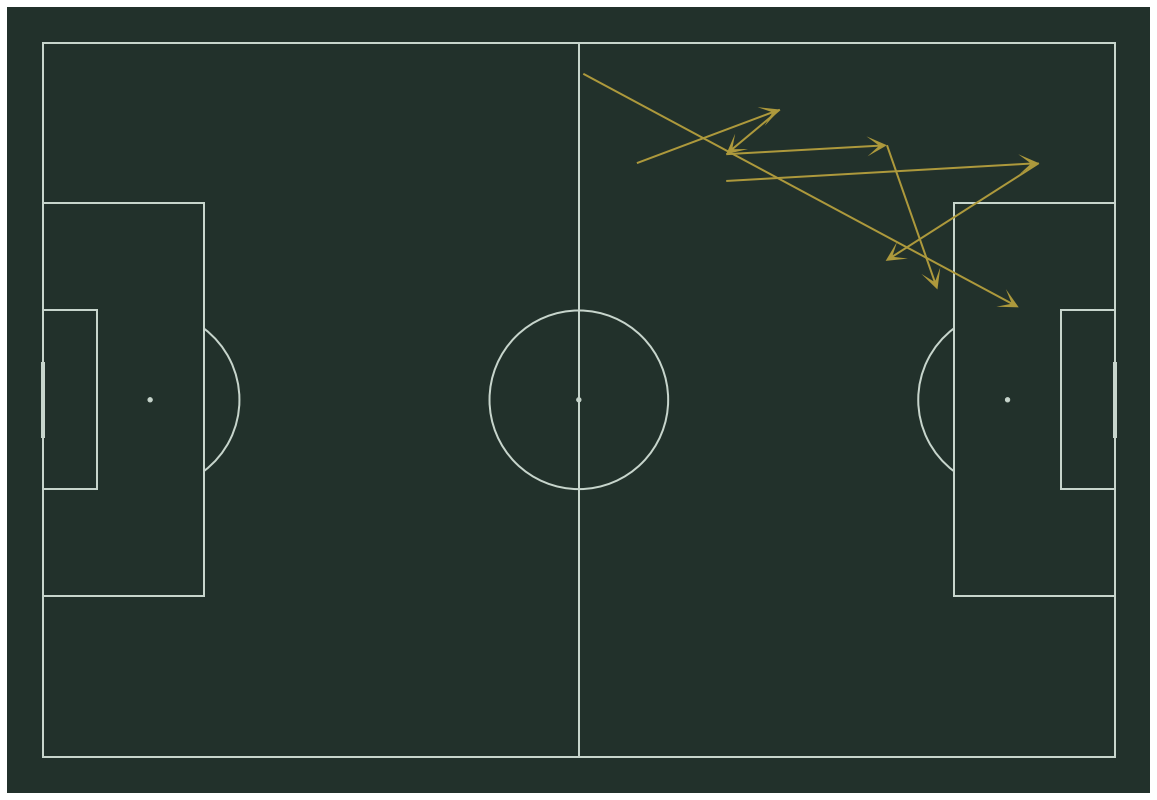

In [41]:
results = matcher_with_zone.search(dataset, pattern=r"(PH1)+SH")
plot_results(results)

# Playing around with the plot

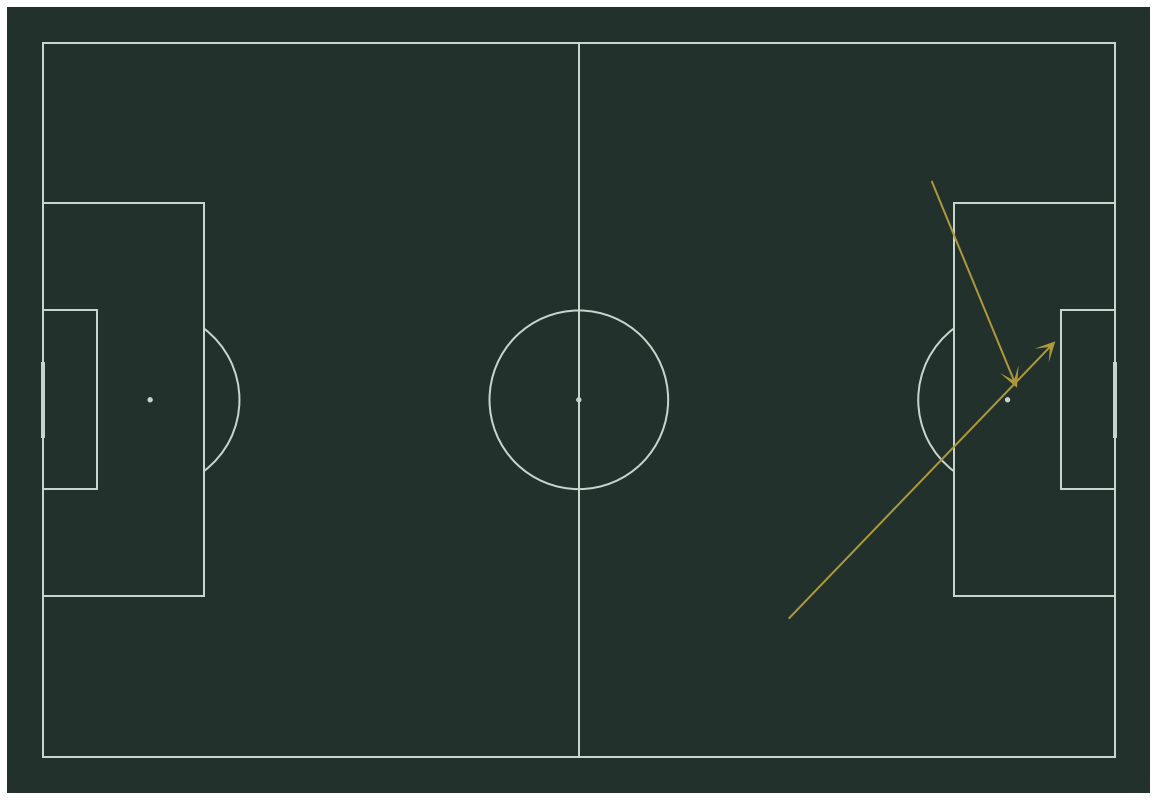

In [46]:
results = matcher_with_zone.search(dataset, pattern=r"PA.SA")
plot_results(results)

# Thanks for watching

Find us:
- twitter https://twitter.com/PySportOrg
- discord: https://t.co/oRtc3ZBrDh
- github: https://github.com/PySport
- docs: https://kloppy.pysport.org